In [ ]:
import json

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

with open("./data/yelp_academic_dataset_review.json", encoding="utf-8") as f:
    data = [json.loads(line) for line in f]
print(data.__class__)
print(data[0].keys())
print(data[0]["stars"])
print(data[1]["stars"])
# print(data)
texts = [d["text"] for d in data]
labels = [1 if d["stars"] >= 4 else 0 for d in data]  # 4-5星為正評，1-2星為負評
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)
print(len(X_train))
print(len(X_test))

2025-03-30 11:58:55.386935: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 11:58:55.398221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743307135.410993   36123 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743307135.416225   36123 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743307135.426575   36123 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

<class 'list'>
dict_keys(['votes', 'user_id', 'review_id', 'stars', 'date', 'text', 'type', 'business_id'])
5
5
183925
45982


In [2]:
vocab_size = 10000
max_length = 200
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(
    X_train_seq, maxlen=max_length, padding="post", truncating="post"
)
X_test_pad = pad_sequences(
    X_test_seq, maxlen=max_length, padding="post", truncating="post"
)
y_train = np.array(y_train)
y_test = np.array(y_test)
print(X_train_pad.shape)
print(X_test_pad.shape)

(183925, 200)
(45982, 200)


In [4]:
# 模型規劃與編譯 ->後續會做替換
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(vocab_size, 128, input_length=max_length),
        tf.keras.layers.LSTM(
            256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3
        ),
        tf.keras.layers.LSTM(
            128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3
        ),
        tf.keras.layers.GRU(
            128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3
        ),
        tf.keras.layers.GRU(
            64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3
        ),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()


# 訓練與圖表顯示
epochs = 10
batch_size = 64
history = model.fit(
    X_train_pad,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_pad, y_test),
)
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.ylabel("model accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.ylabel("model loss")
plt.xlabel("epoch")
plt.legend()
plt.show()


# 預測
def predict_review(text):
    seq = tokenizer.texts_to_sequences([text])
    pad_seq = pad_sequences(seq, maxlen=max_length, padding="post", truncating="post")
    prediction = model.predict(pad_seq)
    return "正評" if prediction[0][0] > 0.5 else "負評"


print(predict_review("The food was terrible, I will never come back!"))
print(predict_review("Amazing experience, the staff was very friendly."))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1304/2874 ━━━━━━━━━━━━━━━━━━━━ 1:01:49 2s/step - accuracy: 0.7143 - loss: 0.5712

KeyboardInterrupt: 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 61s 20ms/step - accuracy: 0.7428 - loss: 0.5251 - val_accuracy: 0.8712 - val_loss: 0.3025
Epoch 2/10
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 62s 22ms/step - accuracy: 0.8860 - loss: 0.2759 - val_accuracy: 0.8771 - val_loss: 0.2917
Epoch 3/10
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - accuracy: 0.9021 - loss: 0.2411 - val_accuracy: 0.8793 - val_loss: 0.2858
Epoch 4/10
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 75s 19ms/step - accuracy: 0.9185 - loss: 0.2070 - val_accuracy: 0.8739 - val_loss: 0.3048
Epoch 5/10
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 82s 20ms/step - accuracy: 0.9337 - loss: 0.1714 - val_accuracy: 0.8696 - val_loss: 0.3306
Epoch 6/10
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 87s 21ms/step - accuracy: 0.9481 - loss: 0.1391 - val_accuracy: 0.8615 - val_loss: 0.4062
Epoch 7/10
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 56s 20ms/step - accuracy: 0.9594 - loss: 0.1097 - val_accuracy: 0.8637 - val_loss: 0.4167
Epoch 8/10
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 57s 20ms/step - accuracy: 0.9689 -

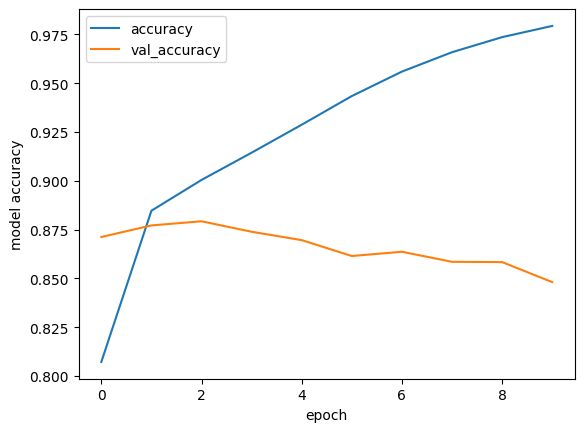

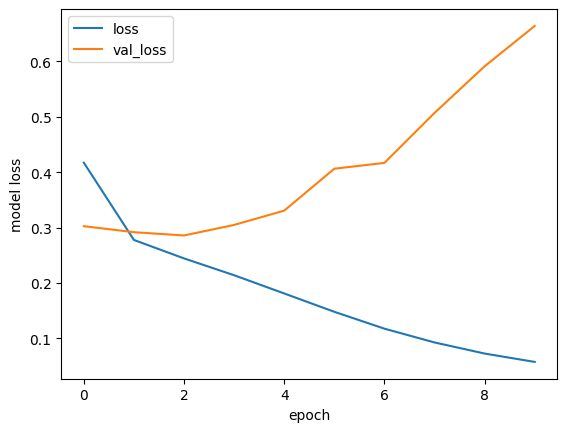

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
負評
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
正評


In [ ]:
# 模型規劃與編譯 ->後續會做替換 :兩層
model = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(vocab_size, 64, input_length=max_length),
        tf.keras.layers.GRU(128, return_sequences=True),
        tf.keras.layers.GRU(64, return_sequences=False),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

# 訓練與圖表顯示
epochs = 10
batch_size = 64
history = model.fit(
    X_train_pad,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_pad, y_test),
)
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.ylabel("model accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.ylabel("model loss")
plt.xlabel("epoch")
plt.legend()
plt.show()


# 預測
def predict_review(text):
    seq = tokenizer.texts_to_sequences([text])
    pad_seq = pad_sequences(seq, maxlen=max_length, padding="post", truncating="post")
    prediction = model.predict(pad_seq)
    return "正評" if prediction[0][0] > 0.5 else "負評"


print(predict_review("The food was terrible, I will never come back!"))
print(predict_review("Amazing experience, the staff was very friendly."))

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 121s 41ms/step - accuracy: 0.7995 - loss: 0.4280 - val_accuracy: 0.8700 - val_loss: 0.3095
Epoch 2/10
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 126s 44ms/step - accuracy: 0.8891 - loss: 0.2668 - val_accuracy: 0.8825 - val_loss: 0.2811
Epoch 3/10
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 144s 44ms/step - accuracy: 0.9071 - loss: 0.2274 - val_accuracy: 0.8788 - val_loss: 0.2872
Epoch 4/10
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 128s 44ms/step - accuracy: 0.9239 - loss: 0.1914 - val_accuracy: 0.8777 - val_loss: 0.3046
Epoch 5/10
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 127s 44ms/step - accuracy: 0.9407 - loss: 0.1514 - val_accuracy: 0.8727 - val_loss: 0.3474
Epoch 6/10
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 127s 44ms/step - accuracy: 0.9547 - loss: 0.1170 - val_accuracy: 0.8694 - val_loss: 0.4092
Epoch 7/10
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 126s 44ms/step - accuracy: 0.9660 - loss: 0.0874 - val_accuracy: 0.8613 - val_loss: 0.4541
Epoch 8/10
2874/2874 ━━━━━━━━━━━━━━━━━━━━ 143s 44ms/step - accuracy: 

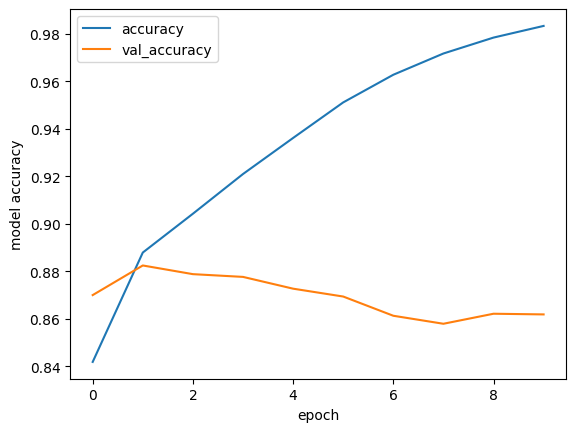

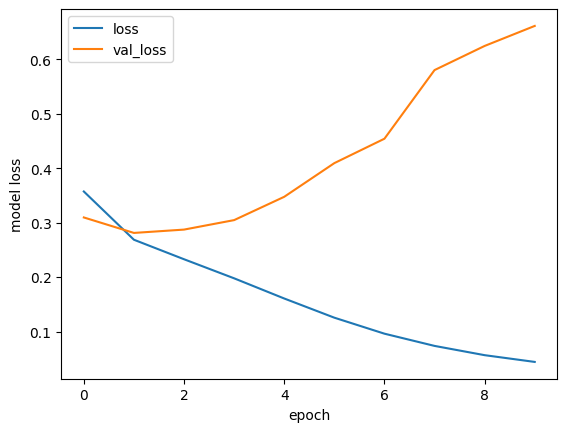

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
負評
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
正評


In [ ]:
# 模型規劃與編譯 ->後續會做替換 :雙向

from tensorflow.keras.layers import GRU, Bidirectional, Dense, Embedding

model = tf.keras.Sequential(
    [
        Embedding(vocab_size, 128, input_length=max_length),
        Bidirectional(GRU(128, return_sequences=True)),
        Bidirectional(GRU(64, return_sequences=False)),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

# 訓練與圖表顯示
epochs = 10
batch_size = 64
history = model.fit(
    X_train_pad,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_pad, y_test),
)
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.ylabel("model accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.ylabel("model loss")
plt.xlabel("epoch")
plt.legend()
plt.show()


# 預測
def predict_review(text):
    seq = tokenizer.texts_to_sequences([text])
    pad_seq = pad_sequences(seq, maxlen=max_length, padding="post", truncating="post")
    prediction = model.predict(pad_seq)
    return "正評" if prediction[0][0] > 0.5 else "負評"


print(predict_review("The food was terrible, I will never come back!"))
print(predict_review("Amazing experience, the staff was very friendly."))